# Time-Series Forecasting using LSTM

## Data exploration and preprocessing

In [ ]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plot
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

# Reading Dataset
airQualityData = pandas.read_csv('./AirQualityUCI.csv')
airQualityDataFrame = pandas.DataFrame(airQualityData) # extracting the data

print(f'Number of samples(time points) - {airQualityDataFrame.shape[0]} & Number of features - {airQualityDataFrame.shape[1]}')
print(airQualityDataFrame.info(),'\n')
print(airQualityDataFrame.describe())

Number of samples(time points) - 9471 & Number of features - 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      f

1. The Air Quality dataset is available at https://archive.ics.uci.edu/dataset/360/air+quality

2. It contains 9,358 instances of hourly averaged sensor data collected from a multisensor device deployed in a polluted urban area in Italy. 

3. The dataset includes concentrations of various pollutants such as CO, NOx, and benzene. 

4. Key variables include the concentrations of gases (e.g., CO, NOx, NO2) and sensor responses corresponding to these pollutants, temperature, and relative and absolute humidity.

2. Identify any missing values.

In [171]:
### ADD YOUR CODE HERE ###

In [172]:
# Missing values in each columns
missingValues = airQualityDataFrame.isnull().sum()
print('\nNumber of missing values in each columns:')
print(missingValues)


Number of missing values in each columns:
Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64


In [ ]:

airQualityDataFrame['Datetime'] = pandas.to_datetime(airQualityDataFrame['Date'] + ' ' + airQualityDataFrame['Time']) # Merging Date, Time colums to get time based filtering
airQualityDataFrame.set_index('Datetime', inplace=True)
airQualityDataFrame.drop(columns=['Date', 'Time'], inplace=True)

# Dropping the unwanted columns
airQualityDataFrame.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)

# Interpolate missing values
airQualityDataFrame.interpolate(method='linear', inplace=True)

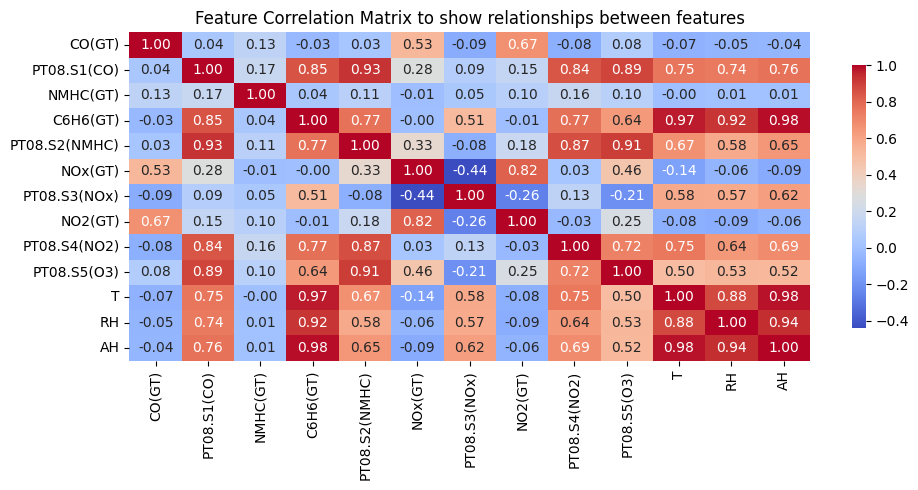

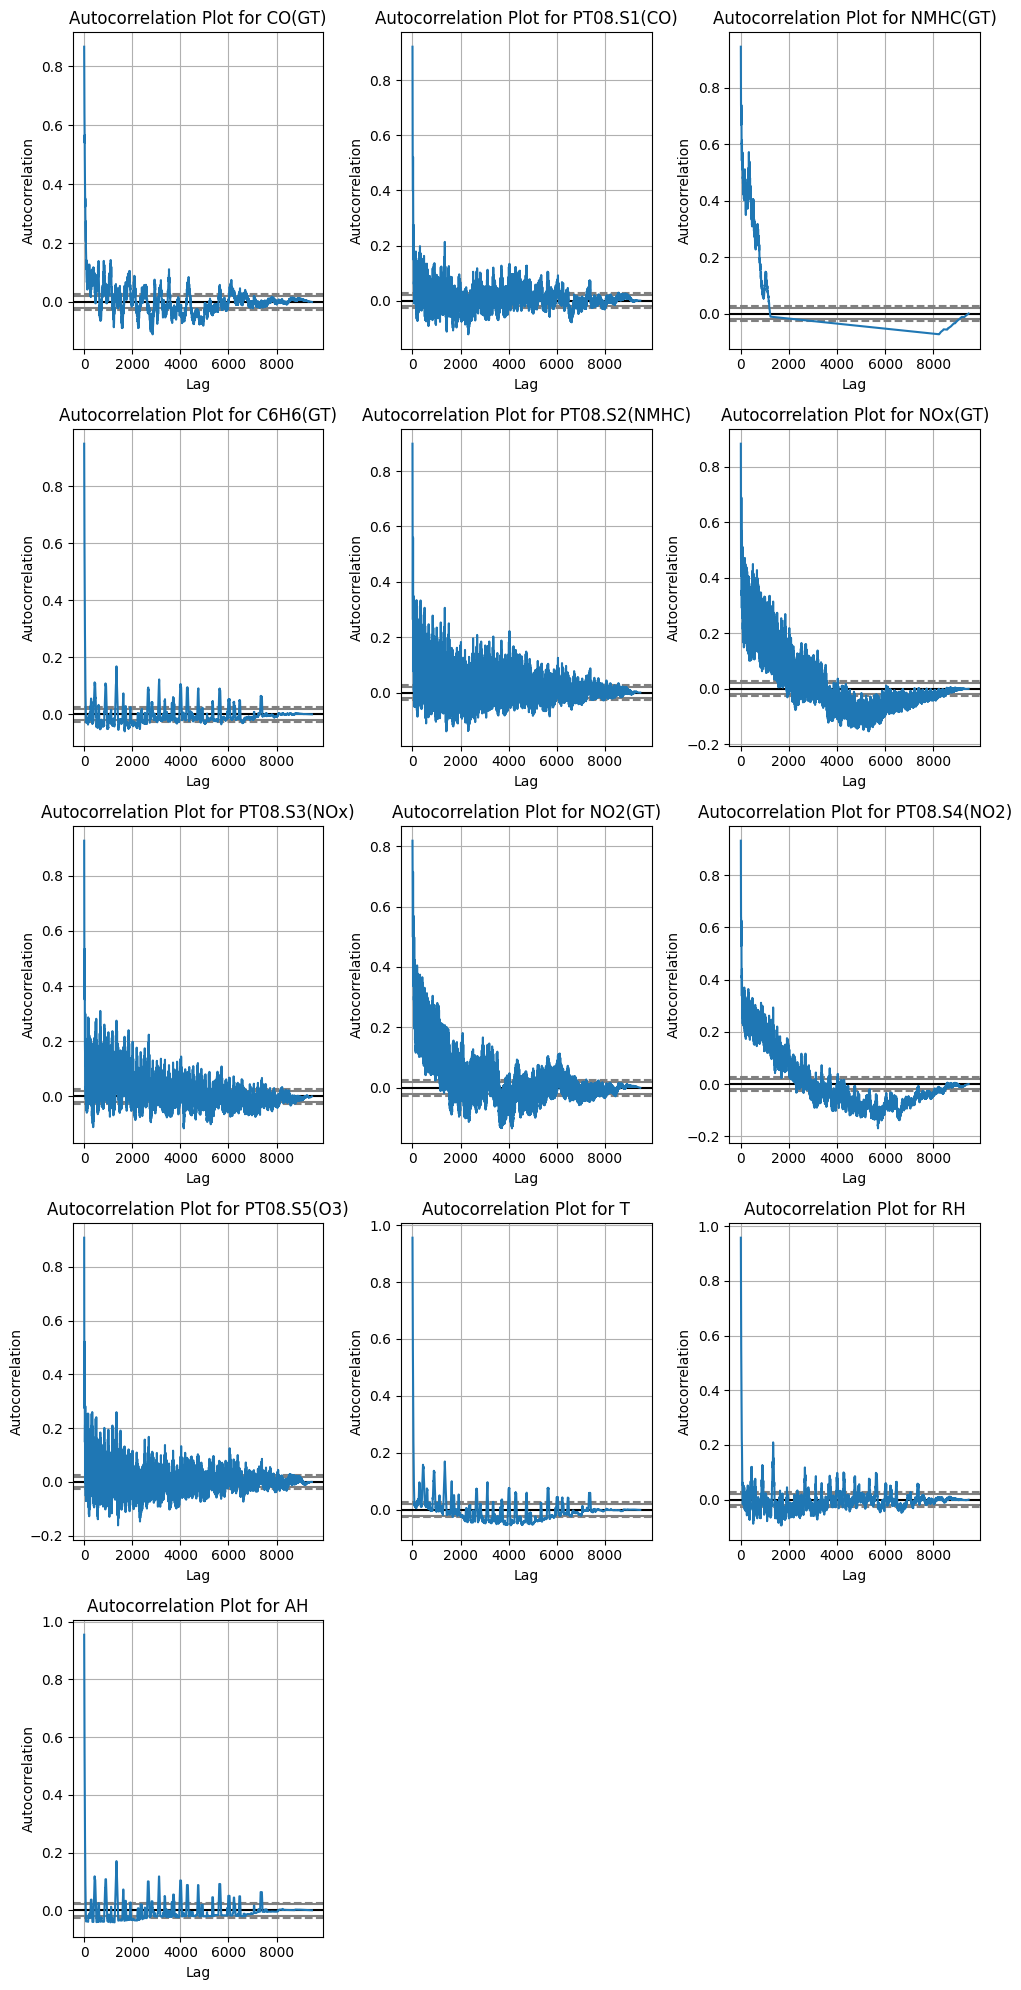

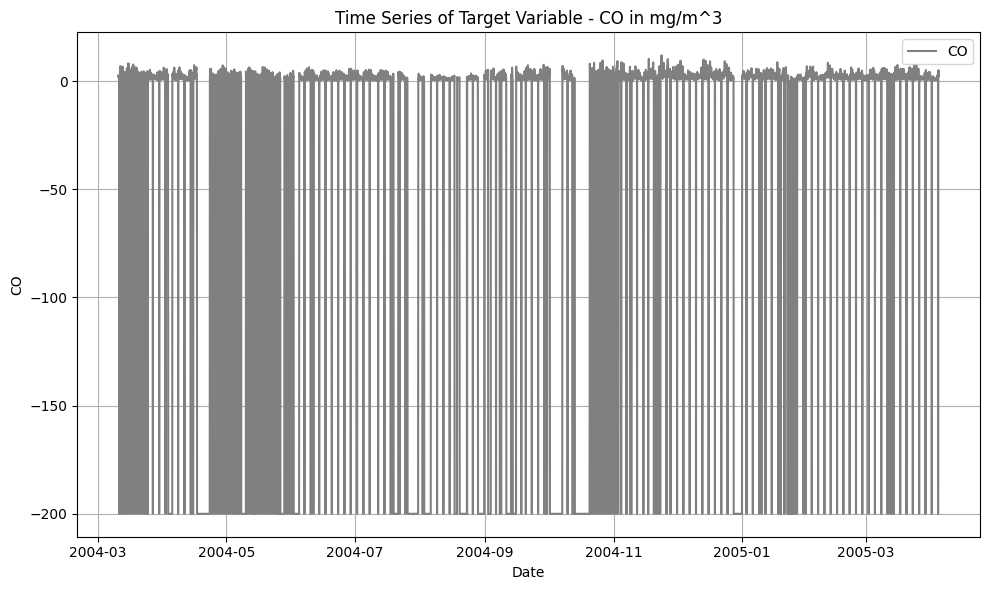

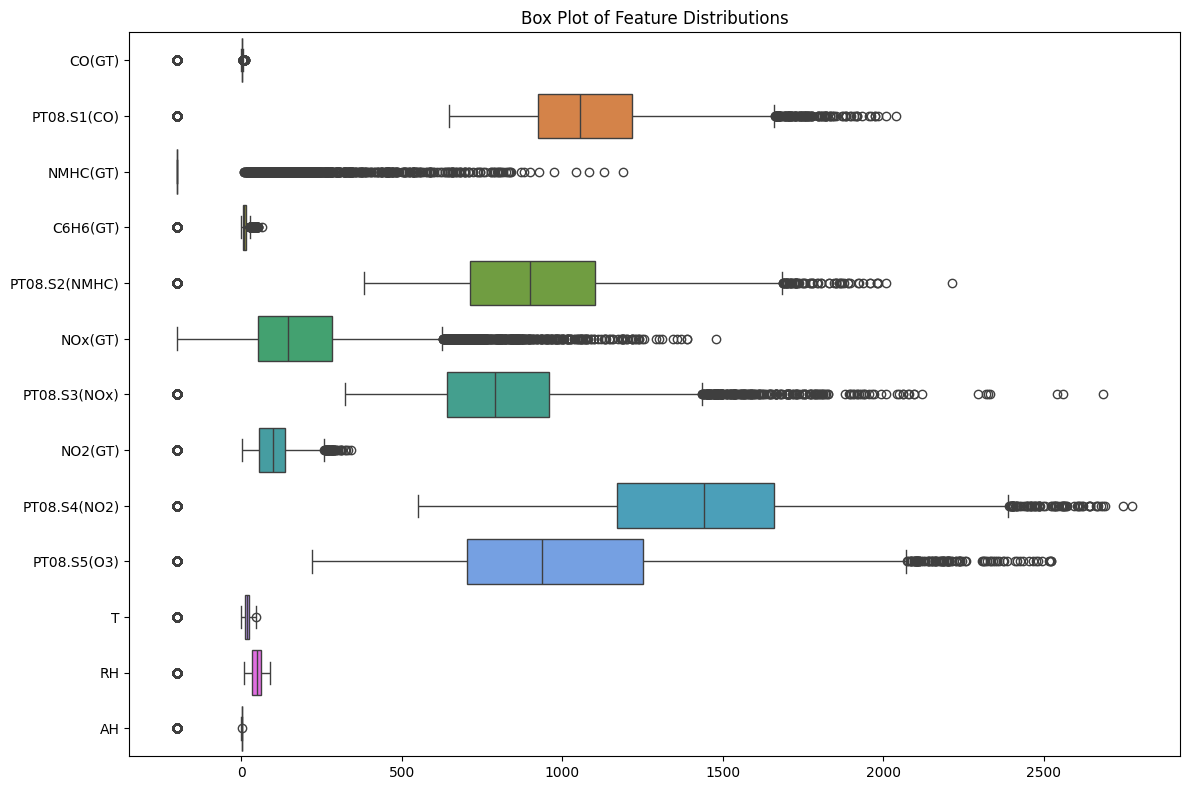

In [176]:
# Plot for orrelation matrix heatmap
plot.figure(figsize = (10,5))
seaborn.heatmap(airQualityDataFrame.corr(), annot=True, cbar_kws={"shrink": 0.8}, fmt=".2f", cmap="coolwarm",)
plot.title("Feature Correlation Matrix to show relationships between features")
plot.tight_layout()
plot.show()

# Plot for Autocorrelation
integerColumns = airQualityDataFrame.select_dtypes(include= numpy.number).columns
columns = len(integerColumns)
rows = (columns + 3 - 1) // 3
fig, axes = plot.subplots(rows, 3, figsize=(10, 4 * rows))
axes = axes.flatten()
for i, column in enumerate(integerColumns):
    autocorrelation_plot(airQualityDataFrame[column], ax=axes[i])
    axes[i].set_title(f'Autocorrelation Plot for {column}')
    axes[i].grid(True)
for j in range(columns, len(axes)):
    axes[j].axis('off')
plot.tight_layout()
plot.show()

# Plot for Time Series for Target Variable
plot.figure(figsize=(10, 6))
plot.plot(airQualityDataFrame.index, airQualityDataFrame['CO(GT)'], label='CO', color='grey')
plot.ylabel('CO')
plot.xlabel('Date')
plot.legend()
plot.grid(True)
plot.title('Time Series of Target Variable - CO in mg/m^3')
plot.tight_layout()
plot.show()


# Plotting box plot for each numeric column
plot.figure(figsize=(12, 8))
seaborn.boxplot(data = airQualityDataFrame[integerColumns], orient='h')
plot.title('Box Plot of Feature Distributions')
plot.tight_layout()
plot.show()


In [ ]:

# List of continuous columns to standardize
continuous_columns = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH']

for i in integerColumns:
    column = airQualityDataFrame[i]

    # Calculate IQR for each column
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Define boundaries
    lowerBoundary = Q1 - 1.5 * IQR
    upperBoundary = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = airQualityDataFrame[(column < lowerBoundary) | (column > upperBoundary)]

    #Impute Outliers with median 
    airQualityDataFrame = airQualityDataFrame[(airQualityDataFrame[i] >= lowerBoundary) & (airQualityDataFrame[i] <= upperBoundary)]

# Initialize the scaler & fit
airQualityDataFrame[integerColumns] = StandardScaler().fit_transform(airQualityDataFrame[integerColumns])


In [179]:
print(airQualityDataFrame.describe())

             CO(GT)   PT08.S1(CO)  NMHC(GT)      C6H6(GT)  PT08.S2(NMHC)  \
count  5.521000e+03  5.521000e+03    5521.0  5.521000e+03   5.521000e+03   
mean   7.207099e-17  3.603549e-16       0.0 -6.177513e-17  -1.029586e-16   
std    1.000091e+00  1.000091e+00       0.0  1.000091e+00   1.000091e+00   
min   -1.726670e+00 -2.400483e+00       0.0 -1.579714e+00  -2.237316e+00   
25%   -7.679783e-01 -7.573184e-01       0.0 -7.903086e-01  -7.684622e-01   
50%   -1.927629e-01 -8.244734e-02       0.0 -1.803137e-01  -5.488656e-02   
75%    5.741908e-01  6.452398e-01       0.0  6.090915e-01   7.003916e-01   
max    3.546137e+00  3.268434e+00       0.0  3.102894e+00   2.535300e+00   

            NOx(GT)  PT08.S3(NOx)       NO2(GT)  PT08.S4(NO2)   PT08.S5(O3)  \
count  5.521000e+03  5.521000e+03  5.521000e+03  5.521000e+03  5.521000e+03   
mean   4.118342e-17 -8.236684e-17  4.118342e-17  2.059171e-16  4.633135e-17   
std    1.000091e+00  1.000091e+00  1.000091e+00  1.000091e+00  1.000091e+00   

In [182]:

trainSize = int(len(airQualityDataFrame) * 0.7)
valSize = int(len(airQualityDataFrame) * 0.15)

# Split the data into train, validation, and test sets
trainData = airQualityDataFrame[:trainSize]
valData = airQualityDataFrame[trainSize:trainSize + valSize]
testData = airQualityDataFrame[trainSize + valSize:]

8. Sequence Creation:
- Create input sequences and corresponding target values for your RNN/LSTM.
- Choose a sequence length.
- Create a function to generate sequences.

In [ ]:
length = 24

def createSequencesBasedOnLength(airQualityDataFrame, length):
    xData = []
    yData = []
    dfLength = len(airQualityDataFrame)
    for i in range(dfLength - length):
        x = airQualityDataFrame.iloc[i:i + length].values
        xData.append(x)
        y = airQualityDataFrame.iloc[i + length].values
        yData.append(y)
    xData = numpy.array(xData)
    yData = numpy.array(yData)
    return xData, yData

# Training, validation, test sets
xTrain, yTrain = createSequencesBasedOnLength(trainData, length)
xVal, yVal = createSequencesBasedOnLength(valData, length)
xTest, yTest = createSequencesBasedOnLength(testData, length)

# Shapes
print(f"xTrain shape: {xTrain.shape}, yTrain shape: {yTrain.shape}")
print(f"xVal shape: {xVal.shape}, yVal shape: {yVal.shape}")
print(f"xTest shape: {xTest.shape}, yTest shape: {yTest.shape}")


xTrain shape: (3840, 24, 13), yTrain shape: (3840, 13)
xVal shape: (804, 24, 13), yVal shape: (804, 13)
xTest shape: (805, 24, 13), yTest shape: (805, 13)


In [186]:
# Convert to DataLoader
trainDataset = TensorDataset(torch.tensor(xTrain, dtype=torch.float32), torch.tensor(yTrain, dtype=torch.float32))
valDataset = TensorDataset(torch.tensor(xVal, dtype=torch.float32), torch.tensor(yVal, dtype=torch.float32))
testDataset = TensorDataset(torch.tensor(xTest, dtype=torch.float32), torch.tensor(yTest, dtype=torch.float32))

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=False)


## Step 2: Model development

1. Choose either an RNN or LSTM network for your time-series forecasting task.

In [ ]:
class LSTMModel(torch.nn.Module): # I'm choosing LSTM
    def __init__(self, numLayers, inputSize, outputSize, hiddenSize, dropout, bidirectional):
        super(LSTMModel, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = inputSize, hidden_size = hiddenSize, num_layers = numLayers, batch_first=True, bidirectional=bidirectional)
        
        adjustingSize = hiddenSize * (2 if bidirectional else 1)  # Adjusting if it is bidirectional
        self.fc1 = torch.nn.Linear(adjustingSize, 128) 
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(128)  # Batch Normalization
        self.dropout1 = torch.nn.Dropout(dropout) # Adding dropout

        self.fc2 = torch.nn.Linear(128, 64)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(dropout)
        self.fc3 = torch.nn.Linear(64, outputSize)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :] # taking last time step
        x = self.fc1(output)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)  # Final output
        return x

# Model Hyperparameters
inputSize = 13
hiddenSize = 64
numLayers = 3
outputSize = 13
dropout = 0.2
bidirectional = False

# Using MSELoss for regression
lossFunction = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(numLayers, inputSize, outputSize, hiddenSize, dropout, bidirectional).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

# printing model summary
summary(model, input_size=(64, 10, 13))


Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [64, 13]                  --
├─LSTM: 1-1                              [64, 10, 64]              86,784
├─Linear: 1-2                            [64, 128]                 8,320
├─ReLU: 1-3                              [64, 128]                 --
├─BatchNorm1d: 1-4                       [64, 128]                 256
├─Dropout: 1-5                           [64, 128]                 --
├─Linear: 1-6                            [64, 64]                  8,256
├─ReLU: 1-7                              [64, 64]                  --
├─Dropout: 1-8                           [64, 64]                  --
├─Linear: 1-9                            [64, 13]                  845
Total params: 104,461
Trainable params: 104,461
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 56.67
Input size (MB): 0.03
Forward/backward pass size (MB): 0.50
Params size (MB): 0.42
Estimated Total S

In [ ]:
# Initializing TensorBoard writer
writer = SummaryWriter()

# Train model
def trainModel(model, trainLoader, valLoader, optimizer, iterations, patience):
    bestMSE = float("inf")
    bestModel = None
    earlyStoppingPatience = 0
    trainLosses, valLosses = [], []

    for iteration in range(iterations):
        runningLoss = 0.0
        model.train()
        for inputs, labels in trainLoader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossFunction(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss = runningLoss + loss.item()

        trainLoss = runningLoss / len(trainLoader)
        trainLosses.append(trainLoss)

        # Validation loss
        valLoss = 0.0
        model.eval()

        with torch.no_grad():
            for inputs, labels in valLoader:
                outputs = model(inputs)
                loss = lossFunction(outputs, labels)
                valLoss = valLoss + loss.item()

        valLoss = valLoss / len(valLoader)
        valLosses.append(valLoss)

        # Storing best model based on lowest  MSE
        if valLoss < bestMSE:
            bestModel = model
            earlyStoppingPatience = 0
            bestMSE = valLoss
        else:
            earlyStoppingPatience = earlyStoppingPatience + 1

        # Early stopping
        if earlyStoppingPatience >= patience:
            print(f"Early stopping triggered at epoch {iteration+1} due to no improvement in MSE")
            break

        print(f"Iteration [{iteration+1}/{iterations}], Training MSE: {trainLoss:.4f}, Validation MSE: {valLoss:.4f}")

    return bestModel, trainLosses, valLosses

def evaluate(model, dataLoader):
    predictions = []
    actuals = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataLoader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(labels.numpy())

    predictions = numpy.array(predictions)
    actuals = numpy.array(actuals)

    # MSE
    mse = mean_squared_error(actuals, predictions)
    rmse = numpy.sqrt(mse)  # Root Mean Squared Error
    mae = mean_absolute_error(actuals, predictions)  # MAE
    r2 = r2_score(actuals, predictions)  # R square

    return mse, mae, rmse, r2, predictions, actuals

# Plotting metrics
def plotsMetrics(mse, mae, r2, rmse,  trainLosses, iterations, valLosses, predictions, actuals):
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R square: {r2:.4f}")
    print(f'Accuracy based on R square: {100*r2:.4f}%')

    # Ploting Training and Validation Loss
    plot.figure(figsize = (10, 4))
    plot.plot(range(iterations), trainLosses, label="Training Loss")
    plot.plot(range(iterations), valLosses, label="Validation Loss")
    plot.xlabel("Epochs")
    plot.ylabel("Loss")
    plot.title("Training and Validation Loss Curves")
    plot.legend()
    plot.show()

    # Predicted vs Actual plot for Regression
    plot.figure(figsize=(10, 4))
    plot.scatter(actuals, predictions, alpha = 0.5)
    plot.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color = 'blue', linestyle='--')
    plot.ylabel("Predicted Values")
    plot.xlabel("Actual Values")
    plot.title("Predicted vs Actual Values for Regression")
    plot.show()

    # Metrics to TensorBoard
    writer.add_scalar('MSE', mse)
    writer.add_scalar('MAE', mae)
    writer.add_scalar('RMSE', rmse)
    writer.add_scalar('R2', r2)

    # Closing writer
    writer.close()

2. Train your model using an appropriate loss function and optimizer.

Training with hyperparameters: {'iterations': 10, 'lr': 0.01, 'hiddenSize': 64, 'dropout': 0.2, 'bidirectional': True}
Iteration [1/10], Training MSE: 0.3745, Validation MSE: 0.4830
Iteration [2/10], Training MSE: 0.2807, Validation MSE: 0.5949
Iteration [3/10], Training MSE: 0.2666, Validation MSE: 0.4420
Iteration [4/10], Training MSE: 0.2614, Validation MSE: 0.3249
Iteration [5/10], Training MSE: 0.2525, Validation MSE: 0.3710
Iteration [6/10], Training MSE: 0.2373, Validation MSE: 0.3172
Iteration [7/10], Training MSE: 0.2444, Validation MSE: 0.3468
Iteration [8/10], Training MSE: 0.2253, Validation MSE: 0.3297
Iteration [9/10], Training MSE: 0.2171, Validation MSE: 0.2918
Iteration [10/10], Training MSE: 0.2141, Validation MSE: 0.2759
MSE: 0.3285
MAE: 0.4298
RMSE: 0.5732
R square: 0.6191
Accuracy based on R square: 61.9050%


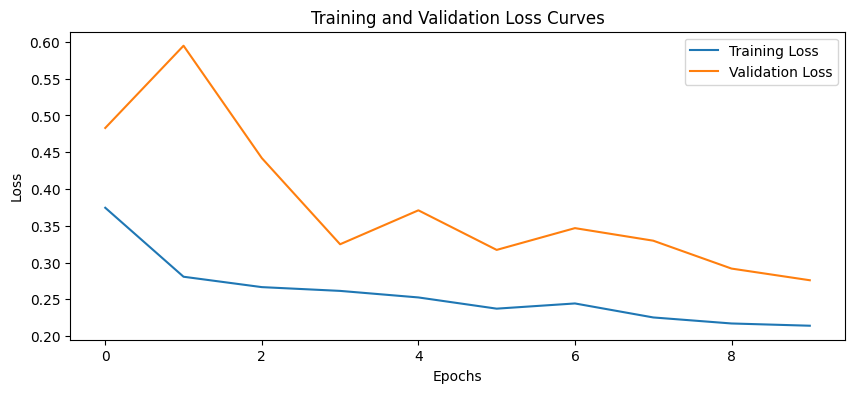

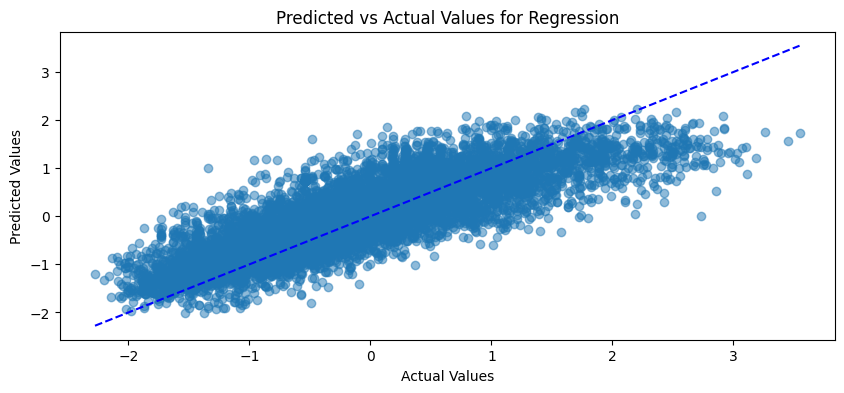

Training with hyperparameters: {'iterations': 10, 'lr': 0.001, 'hiddenSize': 64, 'dropout': 0.2, 'bidirectional': False}
Iteration [1/10], Training MSE: 0.4951, Validation MSE: 0.8887
Iteration [2/10], Training MSE: 0.2770, Validation MSE: 0.3045
Iteration [3/10], Training MSE: 0.2507, Validation MSE: 0.2647
Iteration [4/10], Training MSE: 0.2429, Validation MSE: 0.2383
Iteration [5/10], Training MSE: 0.2277, Validation MSE: 0.2479
Iteration [6/10], Training MSE: 0.2263, Validation MSE: 0.2522
Iteration [7/10], Training MSE: 0.2181, Validation MSE: 0.2474
Iteration [8/10], Training MSE: 0.2200, Validation MSE: 0.2543
Iteration [9/10], Training MSE: 0.2094, Validation MSE: 0.2416
Iteration [10/10], Training MSE: 0.2086, Validation MSE: 0.2344
MSE: 0.2687
MAE: 0.3654
RMSE: 0.5183
R square: 0.6885
Accuracy based on R square: 68.8452%


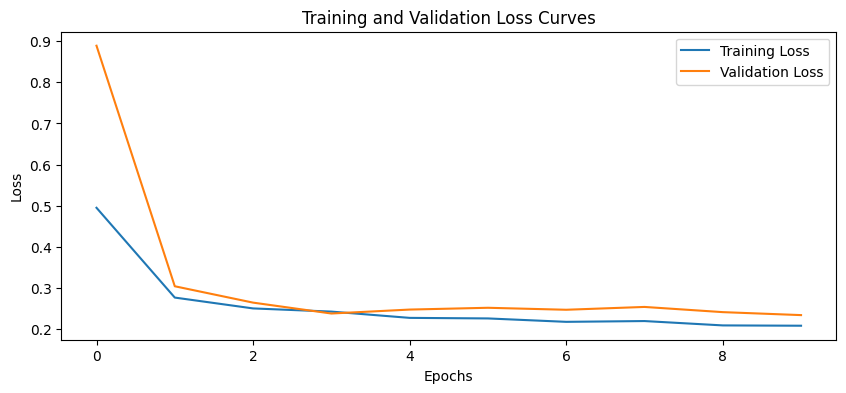

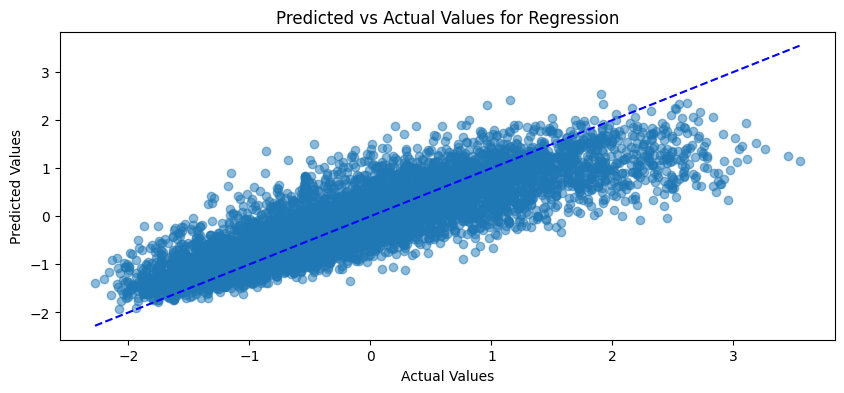

Training with hyperparameters: {'iterations': 10, 'lr': 0.001, 'hiddenSize': 64, 'dropout': 0.2, 'bidirectional': True}
Iteration [1/10], Training MSE: 0.4210, Validation MSE: 0.7203
Iteration [2/10], Training MSE: 0.2696, Validation MSE: 0.2785
Iteration [3/10], Training MSE: 0.2468, Validation MSE: 0.2723
Iteration [4/10], Training MSE: 0.2332, Validation MSE: 0.2479
Iteration [5/10], Training MSE: 0.2297, Validation MSE: 0.2364
Iteration [6/10], Training MSE: 0.2210, Validation MSE: 0.2231
Iteration [7/10], Training MSE: 0.2137, Validation MSE: 0.2167
Iteration [8/10], Training MSE: 0.2076, Validation MSE: 0.2236
Iteration [9/10], Training MSE: 0.2105, Validation MSE: 0.2343
Iteration [10/10], Training MSE: 0.2022, Validation MSE: 0.2115
MSE: 0.2056
MAE: 0.3210
RMSE: 0.4534
R square: 0.7616
Accuracy based on R square: 76.1596%


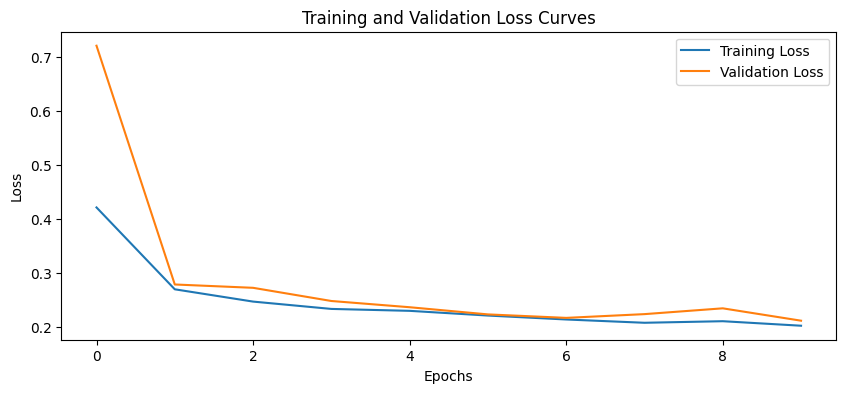

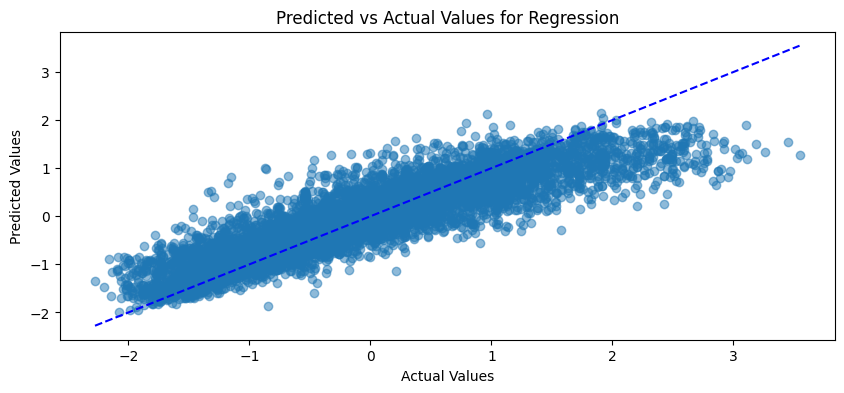

Training with hyperparameters: {'iterations': 50, 'lr': 0.001, 'hiddenSize': 64, 'dropout': 0.2, 'bidirectional': True}
Iteration [1/50], Training MSE: 0.4374, Validation MSE: 0.7939
Iteration [2/50], Training MSE: 0.2747, Validation MSE: 0.2961
Iteration [3/50], Training MSE: 0.2556, Validation MSE: 0.2674
Iteration [4/50], Training MSE: 0.2405, Validation MSE: 0.2475
Iteration [5/50], Training MSE: 0.2330, Validation MSE: 0.2580
Iteration [6/50], Training MSE: 0.2183, Validation MSE: 0.2477
Iteration [7/50], Training MSE: 0.2179, Validation MSE: 0.2190
Iteration [8/50], Training MSE: 0.2159, Validation MSE: 0.2192
Iteration [9/50], Training MSE: 0.2046, Validation MSE: 0.2105
Iteration [10/50], Training MSE: 0.2102, Validation MSE: 0.2182
Iteration [11/50], Training MSE: 0.2019, Validation MSE: 0.2251
Iteration [12/50], Training MSE: 0.1980, Validation MSE: 0.2009
Iteration [13/50], Training MSE: 0.1974, Validation MSE: 0.2193
Iteration [14/50], Training MSE: 0.1967, Validation MSE: 

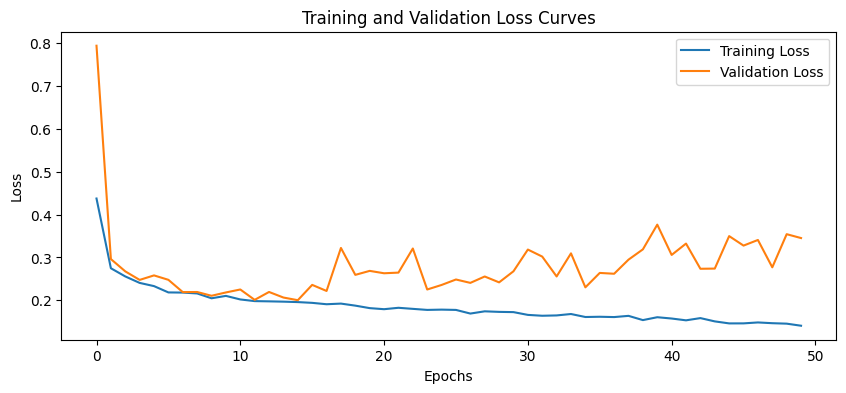

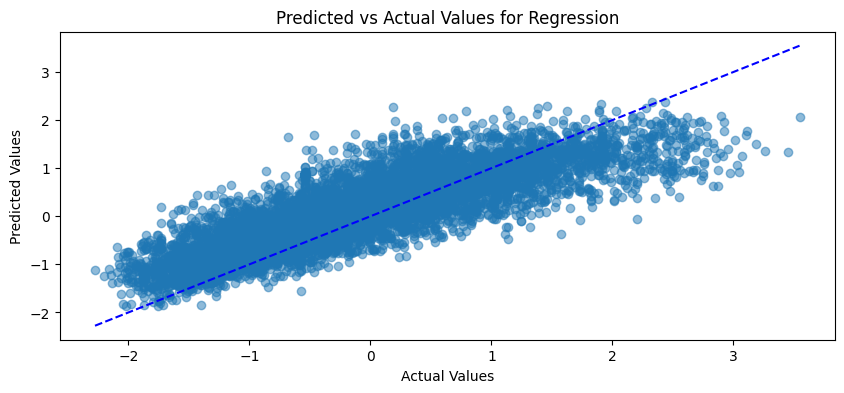

Training with hyperparameters: {'iterations': 30, 'lr': 0.0005, 'hiddenSize': 128, 'dropout': 0.3, 'bidirectional': True}
Iteration [1/30], Training MSE: 0.5261, Validation MSE: 0.8393
Iteration [2/30], Training MSE: 0.3281, Validation MSE: 0.2915
Iteration [3/30], Training MSE: 0.2982, Validation MSE: 0.3202
Iteration [4/30], Training MSE: 0.2781, Validation MSE: 0.2774
Iteration [5/30], Training MSE: 0.2719, Validation MSE: 0.2448
Iteration [6/30], Training MSE: 0.2558, Validation MSE: 0.2327
Iteration [7/30], Training MSE: 0.2574, Validation MSE: 0.2327
Iteration [8/30], Training MSE: 0.2473, Validation MSE: 0.2316
Iteration [9/30], Training MSE: 0.2440, Validation MSE: 0.2318
Iteration [10/30], Training MSE: 0.2404, Validation MSE: 0.2314
Iteration [11/30], Training MSE: 0.2317, Validation MSE: 0.2409
Iteration [12/30], Training MSE: 0.2339, Validation MSE: 0.2629
Iteration [13/30], Training MSE: 0.2284, Validation MSE: 0.2394
Iteration [14/30], Training MSE: 0.2288, Validation MSE

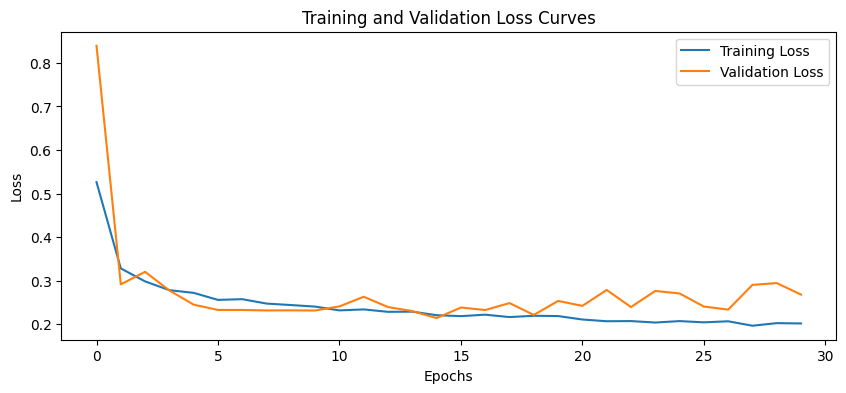

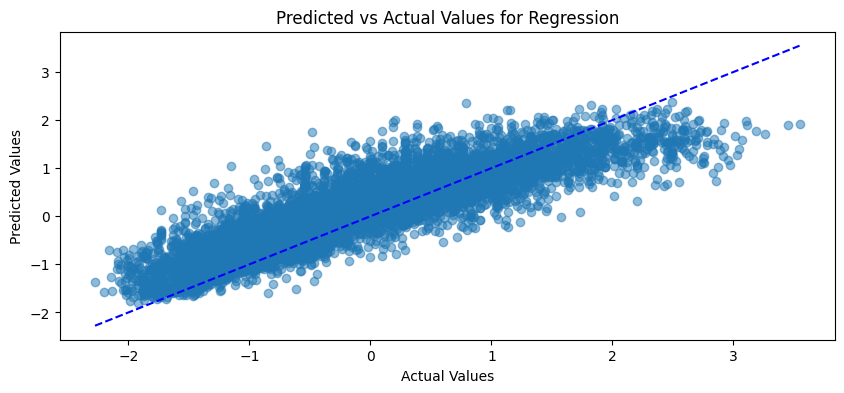

Training with hyperparameters: {'iterations': 50, 'lr': 7e-05, 'hiddenSize': 256, 'dropout': 0.4, 'bidirectional': True}
Iteration [1/50], Training MSE: 0.7145, Validation MSE: 1.0069
Iteration [2/50], Training MSE: 0.5742, Validation MSE: 0.5233
Iteration [3/50], Training MSE: 0.4930, Validation MSE: 0.4477
Iteration [4/50], Training MSE: 0.4377, Validation MSE: 0.3939
Iteration [5/50], Training MSE: 0.4058, Validation MSE: 0.3791
Iteration [6/50], Training MSE: 0.3828, Validation MSE: 0.3952
Iteration [7/50], Training MSE: 0.3594, Validation MSE: 0.3486
Iteration [8/50], Training MSE: 0.3549, Validation MSE: 0.3463
Iteration [9/50], Training MSE: 0.3421, Validation MSE: 0.3603
Iteration [10/50], Training MSE: 0.3349, Validation MSE: 0.3226
Iteration [11/50], Training MSE: 0.3299, Validation MSE: 0.3019
Iteration [12/50], Training MSE: 0.3229, Validation MSE: 0.2964
Iteration [13/50], Training MSE: 0.3192, Validation MSE: 0.2736
Iteration [14/50], Training MSE: 0.3166, Validation MSE:

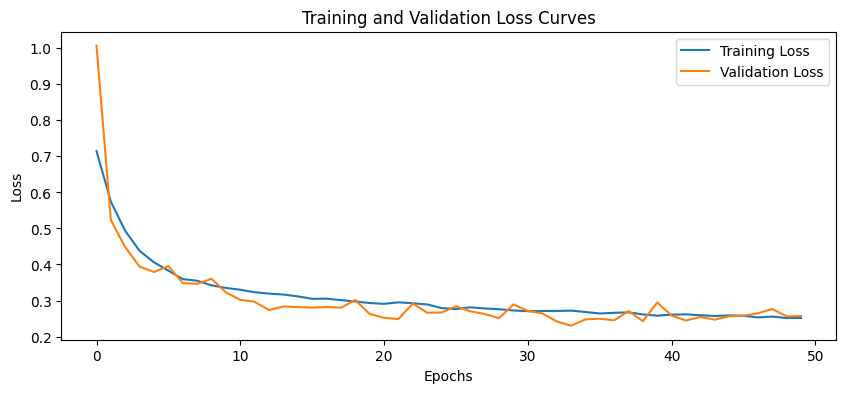

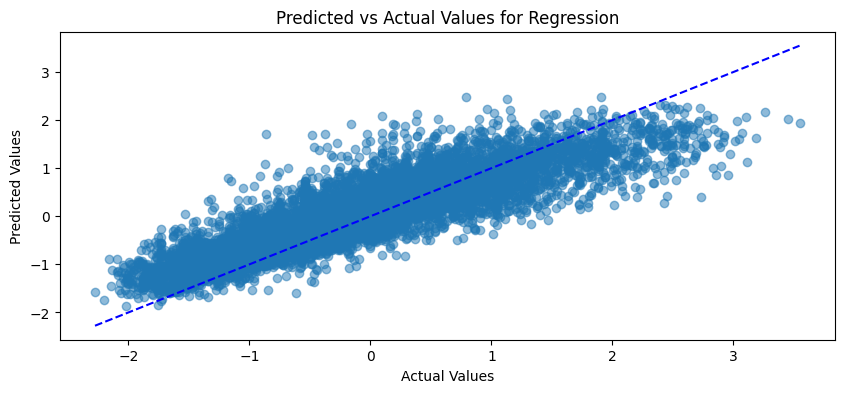

In [ ]:
tuningHyperparameters = [
    {"iterations": 10, "lr": 0.01, "hiddenSize": 64, "dropout": 0.2, 'bidirectional': True},    
    {"iterations": 10, "lr": 0.001, "hiddenSize": 64, "dropout": 0.2, 'bidirectional': False},
    {"iterations": 10, "lr": 0.001, "hiddenSize": 64, "dropout": 0.2, 'bidirectional': True},
    {"iterations": 50, "lr": 0.001, "hiddenSize": 64, "dropout": 0.2, 'bidirectional': True},
    {"iterations": 30, "lr": 0.0005, "hiddenSize": 128, "dropout": 0.3, 'bidirectional': True},
    {"iterations": 50, "lr": 0.00007, "hiddenSize": 256, "dropout": 0.4, 'bidirectional': True}
]

bestModelAfterExperiments = None
bestMSEAfterExperiments = float("inf")
bestAccuracyAfterExperiments = 0


newMSE = 0
newrmse = 0
newR2 = 0
newmae = 0

# Train and evaluate with diff hyperparameters
for hyperparameters in tuningHyperparameters:
    print(f"Training with hyperparameters: {hyperparameters}")

    model = LSTMModel(numLayers, inputSize, outputSize, hiddenSize = hyperparameters['hiddenSize'], dropout = hyperparameters['dropout'], bidirectional = hyperparameters['bidirectional']).to(device)
    optimizer = torch.optim.AdamW(model.parameters(),  lr = hyperparameters["lr"], weight_decay=1e-3)
    
    # Training model
    bestModel, trainLosses, valLosses = trainModel(model, trainLoader, valLoader, optimizer, iterations = hyperparameters["iterations"], patience = 60)
    
    # Test metrics
    mse, mae, rmse, r2, predictions, actuals = evaluate(model, testLoader)
    plotsMetrics(mse, mae, r2, rmse,  trainLosses, len(valLosses), valLosses, predictions, actuals)
    if mse < bestMSEAfterExperiments:
        bestMSEAfterExperiments = mse
        bestModelAfterExperiments = bestModel
        bestAccuracyAfterExperiments = r2*100


Hyperparammeter Tuning Strategy : Manual Search where in a set of hyperparameter combinations  is explicitly defined.
<br>
| Iterations | Learning Rate (lr) | Hidden Size | Dropout | Bidirectional | R-squared |
| :--------- | :----------------- | :---------- | :------ | :------------ | :---------- |
| 10         | 0.01               | 64          | 0.2     | True          | 0.6191      |
| 10         | 0.001              | 64          | 0.2     | False         | 0.6885      |
| 10         | 0.001              | 64          | 0.2     | True          | 0.7616      |
| 50         | 0.001              | 64          | 0.2     | True          | 0.6315      |
| 30         | 0.0005             | 128         | 0.3     | True          | 0.6884      |
| 50         | 0.00007            | 256         | 0.4     | True          | 0.7112      |


## Step 3: Evaluation and analysis

In [196]:
mse, mae, rmse, r2, predictions, actuals = evaluate(model, testLoader)

MSE: 0.2056
MAE: 0.3210
RMSE: 0.4534
R square: 0.7616
Accuracy based on R square: 76.1596%


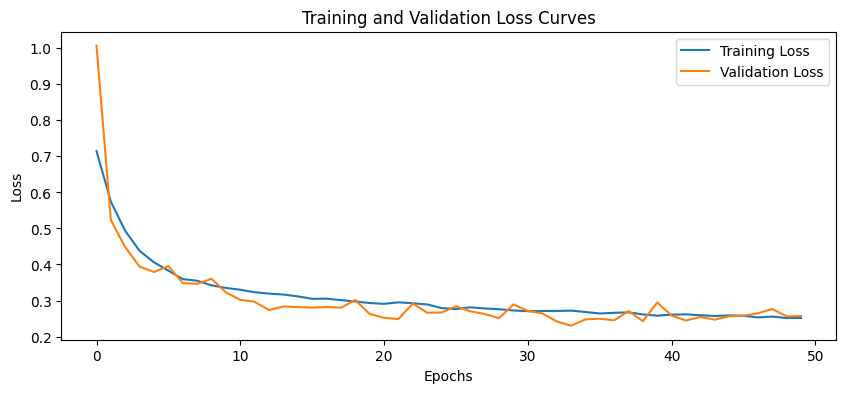

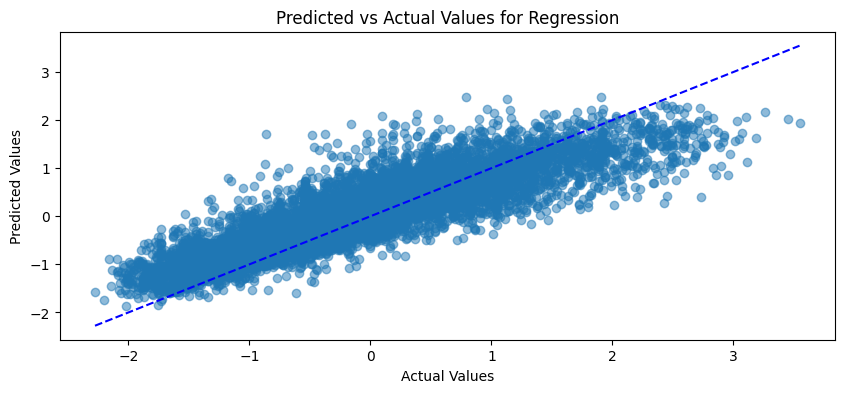

In [ ]:
plotsMetrics(mse, mae, r2, rmse,  trainLosses, len(valLosses), valLosses, predictions, actuals)